Bibliotecas utilizadas

In [25]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics, tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plot


Fixando semente para reprodutibilidade dos resultados

In [26]:
np.random.seed(42)

Leitura dos dados

In [27]:
dataset_mat = pd.read_csv("https://raw.githubusercontent.com/camila-cg/analise-dados-educacionais/main/dados/student-mat-fix.csv")
dataset_port = pd.read_csv("https://raw.githubusercontent.com/camila-cg/analise-dados-educacionais/main/dados/student-por-fix.csv")

dataset_mat.head(2)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6


## Pré-Processamento

### Verificação de dados faltantes

Verificando a presença de dados faltantes na base de dados

In [28]:
print(dataset_mat.info())
print(dataset_port.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

Verificamos que as bases a serem utilizadas não possuem valores faltantes.

### Transformação dos Dados

Os atributos que assumem apenas dois valores possíveis, como os valores **'yes'** e **'no'** serão transformados em valores binários, dado que os modelos de aprendizado de máquina não conseguem trabalhar com strings, apenas números

In [29]:
def labelEncoder(df, colunas, filename):
  label_df = df.copy()
  le = LabelEncoder()
  
  for col in colunas:
    label_df[col] = le.fit_transform(label_df[col])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    # print(col)
    # print(le_name_mapping)
    arq = open(filename, 'a')
    print("Coluna: ", col, file=arq)
    print(le_name_mapping, file=arq)
    print('\n', file=arq)
    arq.close()
  return label_df

colunas_bin = ["school", "sex", "schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic", "address", "famsize", "Pstatus"]

dataset_mat_proc = labelEncoder(dataset_mat, colunas_bin, 'label_encoder.txt')
dataset_port_proc = labelEncoder(dataset_port, colunas_bin, 'label_encoder.txt')

print("Primeira linha do dataset de matemática após a conversão dos atributos binários:")
dataset_mat_proc.head(1)

Primeira linha do dataset de matemática após a conversão dos atributos binários:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6


Agora vamos converter os atributos categóricos que assumem mais do que dois valores possíveis em valores discretos.

In [30]:
colunas_cat = ["Mjob", "Fjob", "reason", "guardian"]

dataset_mat_proc = labelEncoder(dataset_mat_proc, colunas_cat, 'label_cat.txt')
dataset_port_proc = labelEncoder(dataset_port_proc, colunas_cat, 'label_cat.txt')

print("Primeira linha do dataset de matemática após a conversão dos atributos categóricos:")
dataset_mat_proc.head(1)

Primeira linha do dataset de matemática após a conversão dos atributos categóricos:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,0,18,1,0,0,4,4,0,4,...,4,3,4,1,1,3,6,5,6,6


Normalização

In [31]:
def normalizacao(df):
  norm_df = df.copy()
  
  colunas_num = ['age']
  norm_df[colunas_num] = minmax_scale(norm_df[colunas_num])
  # print(norm_df.age.value_counts())
  return norm_df

dataset_mat_proc = normalizacao(dataset_mat_proc)
dataset_port_proc = normalizacao(dataset_port_proc)


Seleção de variáveis

In [32]:
def selecaoDeVariaveis(df):
  # Colunas menos importantes para definição da classe na base processada
  colunas_relief = ["traveltime", "Fjob", "famrel", "guardian", "paid"]
  return df.drop(colunas_relief, axis=1)

dataset_mat_proc = selecaoDeVariaveis(dataset_mat_proc)
dataset_port_proc = selecaoDeVariaveis(dataset_port_proc)

### Adicionando colunas de classe

Será criada uma **classe binária** que indicará se o aluno foi aprovado na disciplina ou não, onde os modelos de classificação deverão prever com base nas informações disponíveis sobre cada aluno se ele será ou não aprovado.

In [33]:
dataset_mat_proc_final = dataset_mat_proc.copy()
dataset_mat_proc_final['aprovado'] = ''
dataset_mat_proc_final.loc[(dataset_mat_proc_final.G3 >= 10), 'aprovado'] = 1
dataset_mat_proc_final.loc[(dataset_mat_proc_final.G3 < 10), 'aprovado'] = 0
dataset_mat_proc_final.drop('G3', axis=1, inplace=True)

dataset_port_proc_final = dataset_port_proc.copy()
dataset_port_proc_final['aprovado'] = ''
dataset_port_proc_final.loc[(dataset_port_proc_final.G3 >= 10), 'aprovado'] = 1
dataset_port_proc_final.loc[(dataset_port_proc_final.G3 < 10), 'aprovado'] = 0
dataset_port_proc_final.drop('G3', axis=1, inplace=True)
dataset_port_proc_final.head(2)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,reason,...,romantic,freetime,goout,Dalc,Walc,health,absences,G1,G2,aprovado
0,0,0,0.428571,1,0,0,4,4,0,0,...,0,3,4,1,1,3,4,0,11,1
1,0,0,0.285714,1,0,1,1,1,0,0,...,0,3,3,1,1,3,2,9,11,1


Será criada também uma coluna que indicará o conceito final do aluno, seguindo a seguinte regra:
- Notas entre [16, 20]: conceito **A**,
- Notas entre [14, 16): conceito **B**,
- Notas entre [12, 14): conceito **C**,
- Notas entre [10, 12): conceito **D** e
- Notas entre [0, 10): conceito **F**

In [34]:
dataset_mat_proc_conceito = dataset_mat_proc.copy()
dataset_mat_proc_conceito['conceito'] = ''
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 0) & (dataset_mat_proc_conceito.G3 < 10), 'conceito'] = 'F'
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 10) & (dataset_mat_proc_conceito.G3 < 12), 'conceito'] = 'D'
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 12) & (dataset_mat_proc_conceito.G3 < 14), 'conceito'] = 'C'
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 14) & (dataset_mat_proc_conceito.G3 < 16), 'conceito'] = 'B'
dataset_mat_proc_conceito.loc[(dataset_mat_proc_conceito.G3 >= 16) & (dataset_mat_proc_conceito.G3 <= 20), 'conceito'] = 'A'
dataset_mat_proc_conceito.drop('G3', axis=1, inplace=True)

dataset_port_proc_conceito = dataset_port_proc.copy()
dataset_port_proc_conceito['conceito'] = ''
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 0) & (dataset_port_proc_conceito.G3 < 10), 'conceito'] = 'F'
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 10) & (dataset_port_proc_conceito.G3 < 12), 'conceito'] = 'D'
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 12) & (dataset_port_proc_conceito.G3 < 14), 'conceito'] = 'C'
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 14) & (dataset_port_proc_conceito.G3 < 16), 'conceito'] = 'B'
dataset_port_proc_conceito.loc[(dataset_port_proc_conceito.G3 >= 16) & (dataset_port_proc_conceito.G3 <= 20), 'conceito'] = 'A'
dataset_port_proc_conceito.drop('G3', axis=1, inplace=True)
dataset_port_proc_conceito.head(3)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,reason,...,romantic,freetime,goout,Dalc,Walc,health,absences,G1,G2,conceito
0,0,0,0.428571,1,0,0,4,4,0,0,...,0,3,4,1,1,3,4,0,11,D
1,0,0,0.285714,1,0,1,1,1,0,0,...,0,3,3,1,1,3,2,9,11,D
2,0,0,0.000000,1,1,1,1,1,0,2,...,0,3,2,2,3,3,6,12,13,C


Por fim, é necessário converter os conceitos criados em valores discretos também.

In [35]:
dataset_mat_proc_conceito = labelEncoder(dataset_mat_proc_conceito, ['conceito'], 'label_cat_conceito.txt')
dataset_port_proc_conceito = labelEncoder(dataset_port_proc_conceito, ['conceito'], 'label_cat_conceito.txt')

### Correlação dos atributos

As bases possuem muitos atributos e talvez nem todos sejam relevantes para a classificação da situação dos alunos em cada disciplina. Para isso é necessária a análise da matriz de correlação.

In [36]:
def plotCorrelationHeatMap(dataFrame, chartTitle):
  correlation = dataFrame.corr(method='pearson') #pearson, kendall, spearman
  plot.figure(figsize=(26, 26))
  # sns.heatmap(correlation, cmap="Greens", annot=True)
  sns.heatmap(correlation, annot=True, fmt=".2f", linewidths=.6)
  plot.title(chartTitle)
  plot.show()


Analisando a correlação com os datasets contendo a nota final (G3):

In [37]:
dataset_mat_proc.corr()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,reason,...,romantic,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
school,1.000000,-0.012286,0.377610,-0.279797,0.064866,0.045923,-0.133333,-0.079807,-0.056670,-0.090010,...,0.060700,0.032988,-0.007152,0.114209,0.065087,-0.042651,-0.088480,-0.025731,-0.050086,-0.045017
sex,-0.012286,1.000000,-0.028606,-0.028504,0.089862,0.023443,0.078228,0.034878,0.191421,-0.095867,...,-0.102023,0.238744,0.075897,0.268171,0.274194,0.143588,-0.066962,0.091839,0.091099,0.103456
age,0.377610,-0.028606,1.000000,-0.146722,0.037847,0.029598,-0.163658,-0.163438,-0.069104,-0.015337,...,0.164669,0.016434,0.126964,0.131125,0.117276,-0.062187,0.175230,-0.064081,-0.143474,-0.161579
address,-0.279797,-0.028504,-0.146722,1.000000,0.072472,-0.042572,0.138804,0.072178,0.108818,-0.047891,...,0.005257,0.034878,0.068835,-0.093494,-0.101126,-0.040355,-0.027874,0.069704,0.126037,0.105756
famsize,0.064866,0.089862,0.037847,0.072472,1.000000,-0.149612,-0.043068,-0.058879,0.071386,-0.019212,...,0.034395,0.017695,0.023064,0.101521,0.103425,-0.028992,0.035783,0.071445,0.081223,0.081407
Pstatus,0.045923,0.023443,0.029598,-0.042572,-0.149612,1.000000,-0.123565,-0.088730,-0.054476,-0.003553,...,-0.040451,0.038717,0.003459,-0.030590,0.006045,0.022307,-0.134937,-0.016868,-0.041382,-0.058009
Medu,-0.133333,0.078228,-0.163658,0.138804,-0.043068,-0.123565,1.000000,0.623455,0.454805,0.117653,...,0.039681,0.030891,0.064094,0.019834,-0.047123,-0.046878,0.100285,0.205341,0.215527,0.217147
Fedu,-0.079807,0.034878,-0.163438,0.072178,-0.058879,-0.088730,0.623455,1.000000,0.243327,0.043099,...,0.015602,-0.012846,0.043105,0.002386,-0.012631,0.014742,0.024473,0.190270,0.164893,0.152457
Mjob,-0.056670,0.191421,-0.069104,0.108818,0.071386,-0.054476,0.454805,0.243327,1.000000,0.022022,...,-0.062999,0.114321,0.003169,0.076076,-0.012051,0.065220,0.050254,0.081674,0.097390,0.102082
reason,-0.090010,-0.095867,-0.015337,-0.047891,-0.019212,-0.003553,0.117653,0.043099,0.022022,1.000000,...,0.018894,-0.066834,-0.050937,-0.048539,-0.044699,-0.157132,0.116909,0.099491,0.117775,0.121994


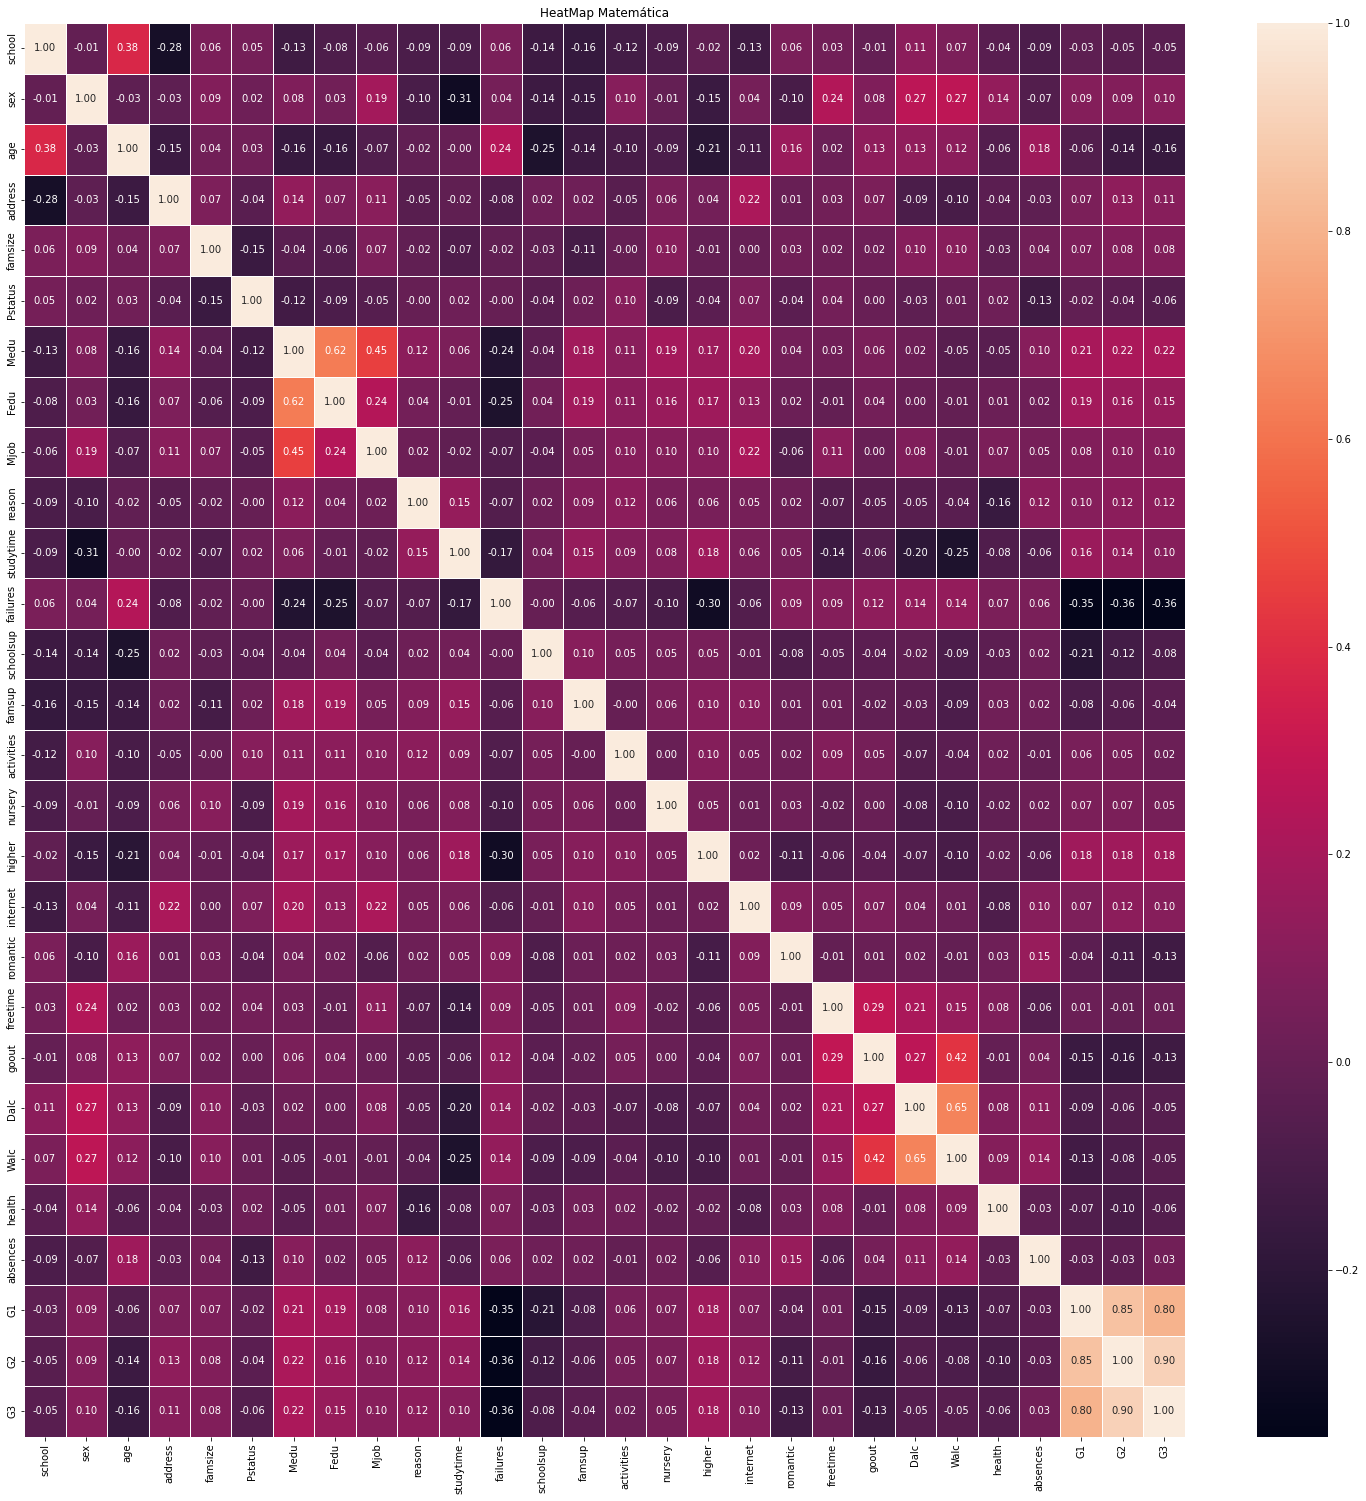

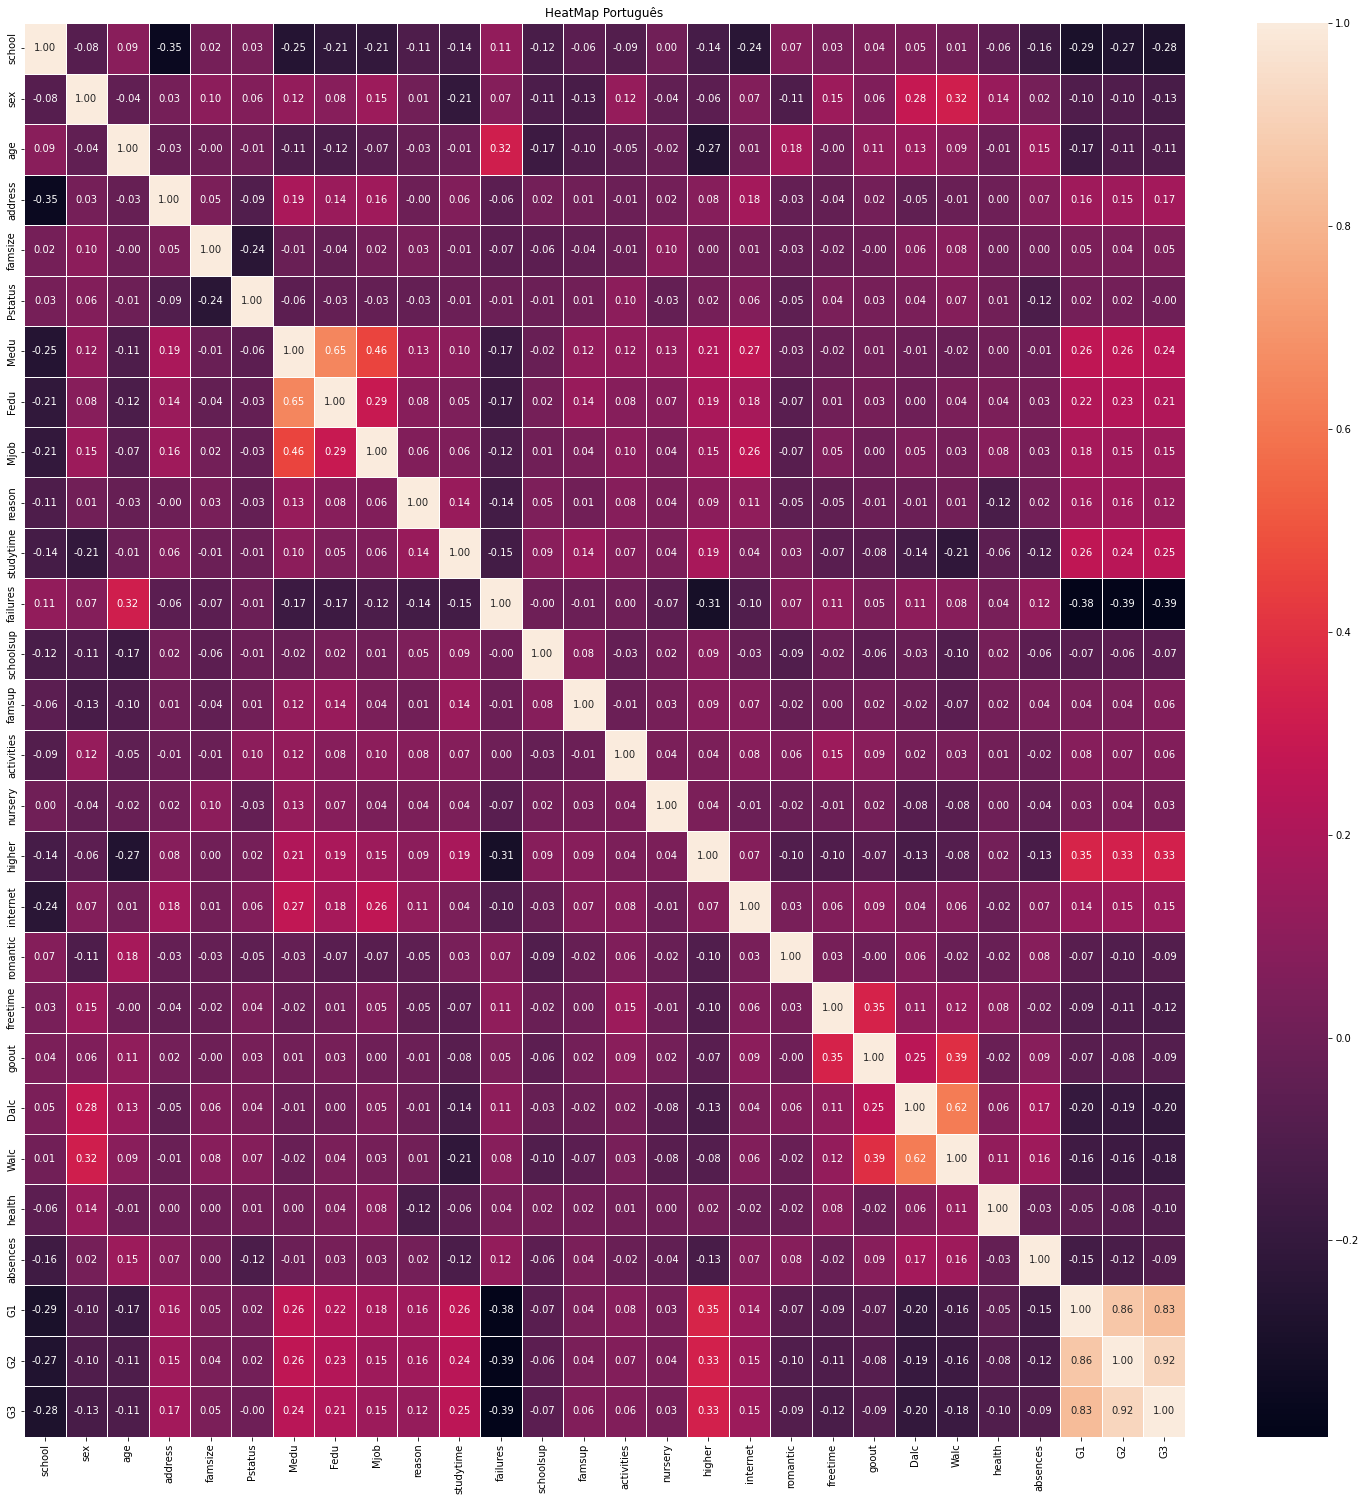

In [38]:
plotCorrelationHeatMap(dataset_mat_proc, 'HeatMap Matemática')
plotCorrelationHeatMap(dataset_port_proc, 'HeatMap Português')

Analisando a correlação com os datasets contendo a situação final do aluno (aprovado ou reprovado):

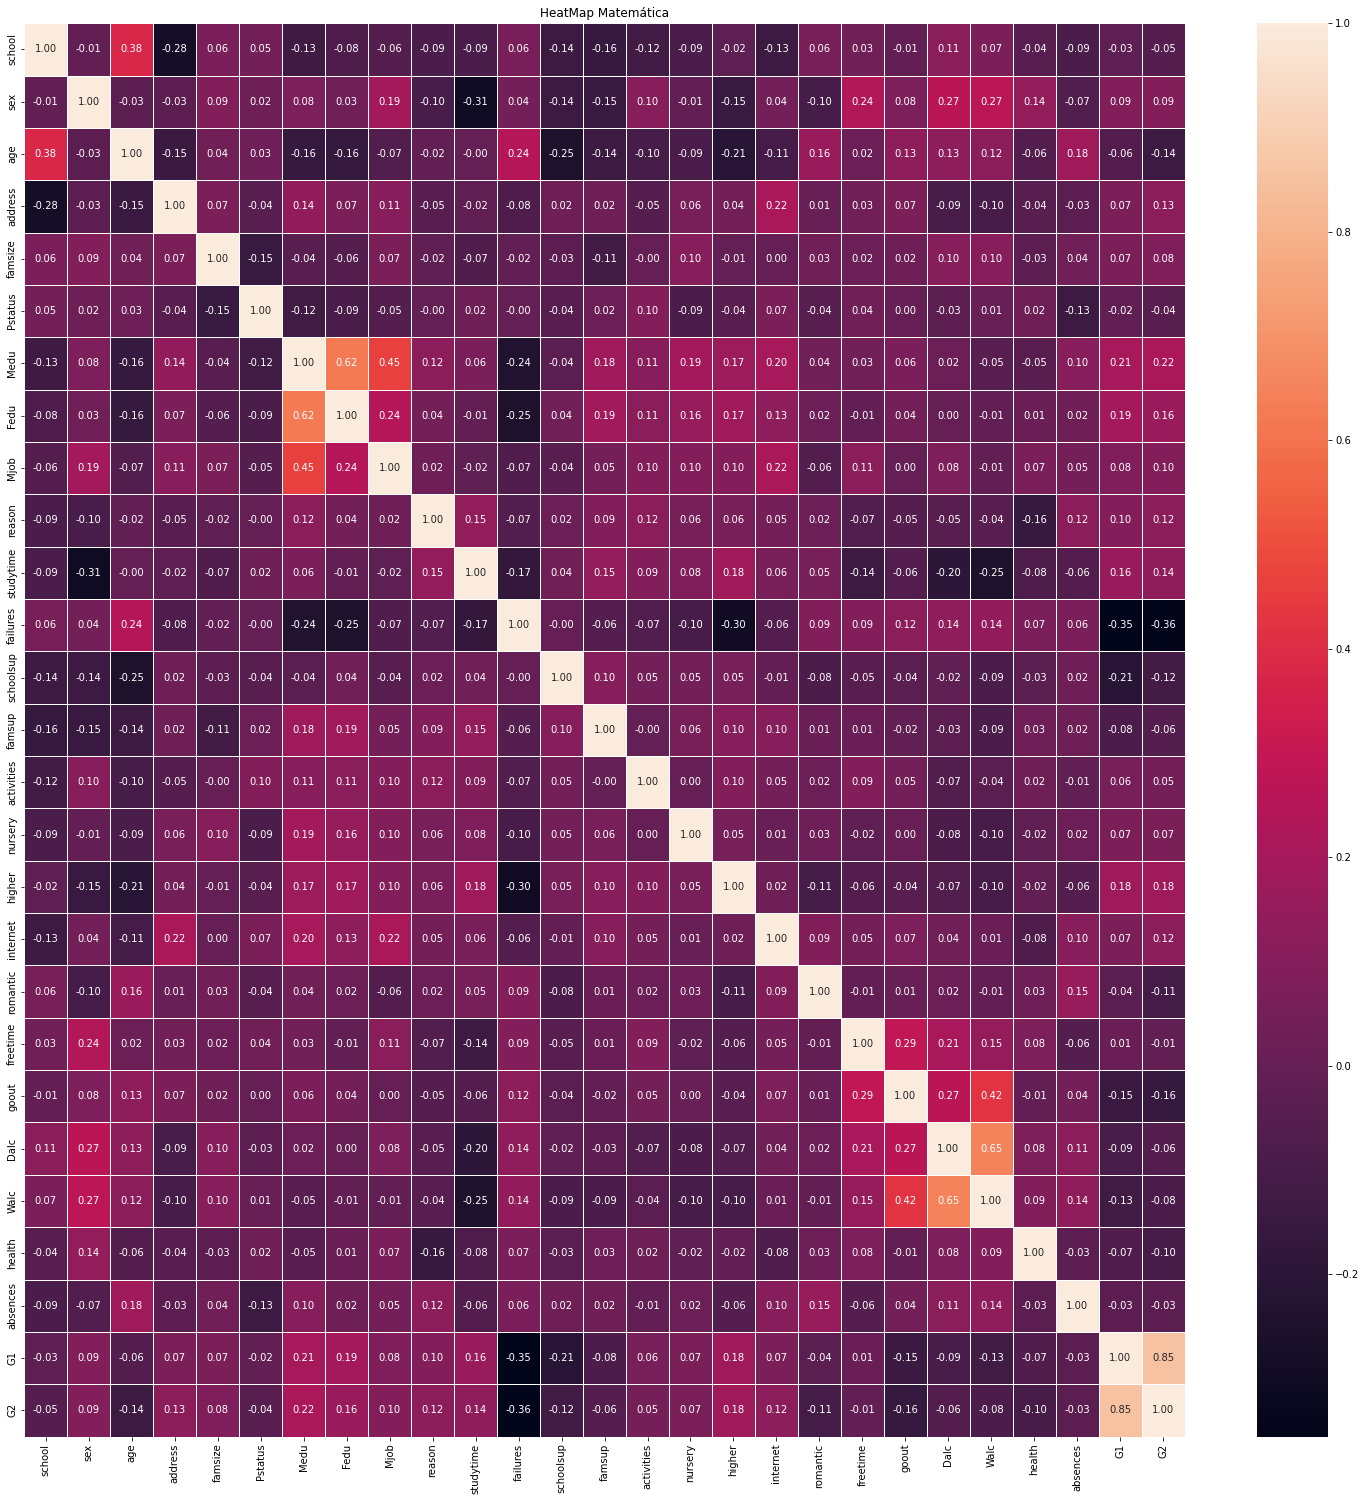

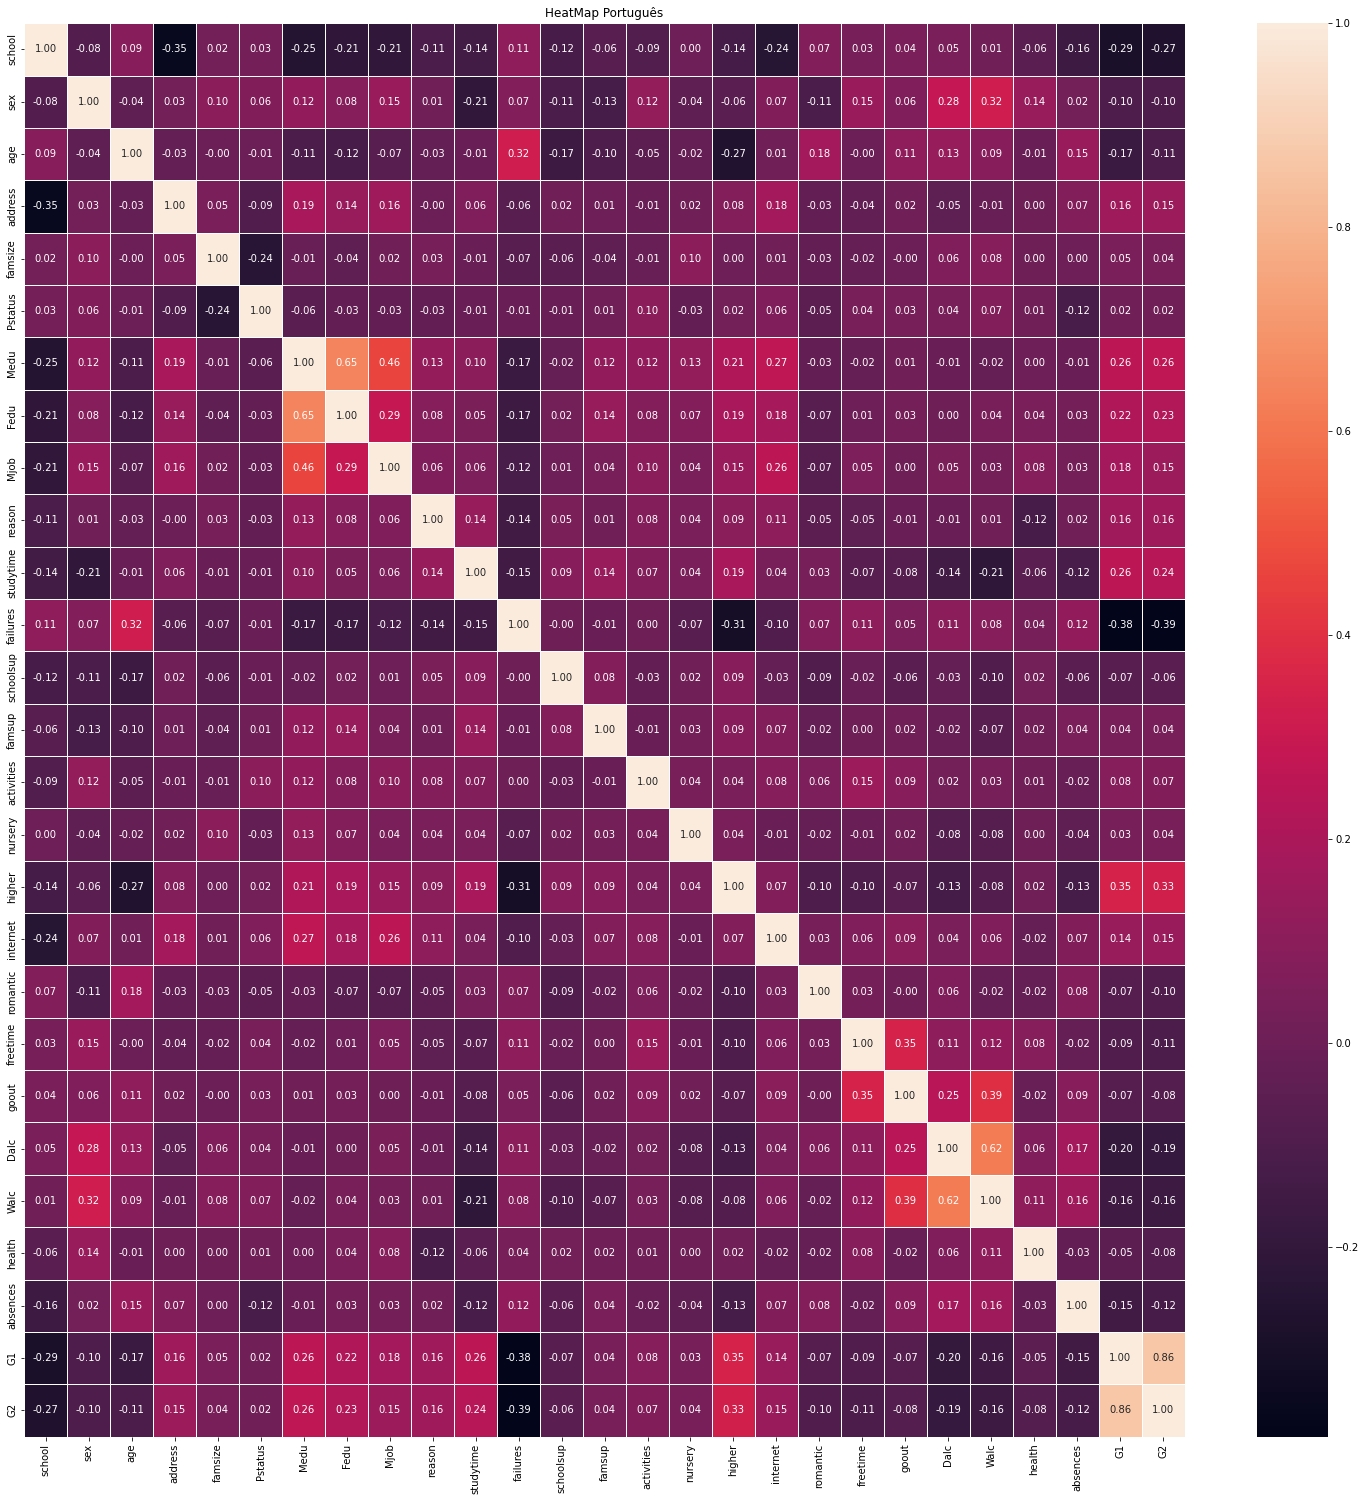

In [39]:
plotCorrelationHeatMap(dataset_mat_proc_final, 'HeatMap Matemática')
plotCorrelationHeatMap(dataset_port_proc_final, 'HeatMap Português')

Analisando a correlação com os datasets contendo o conceito final do aluno (A, B, C, D, F):

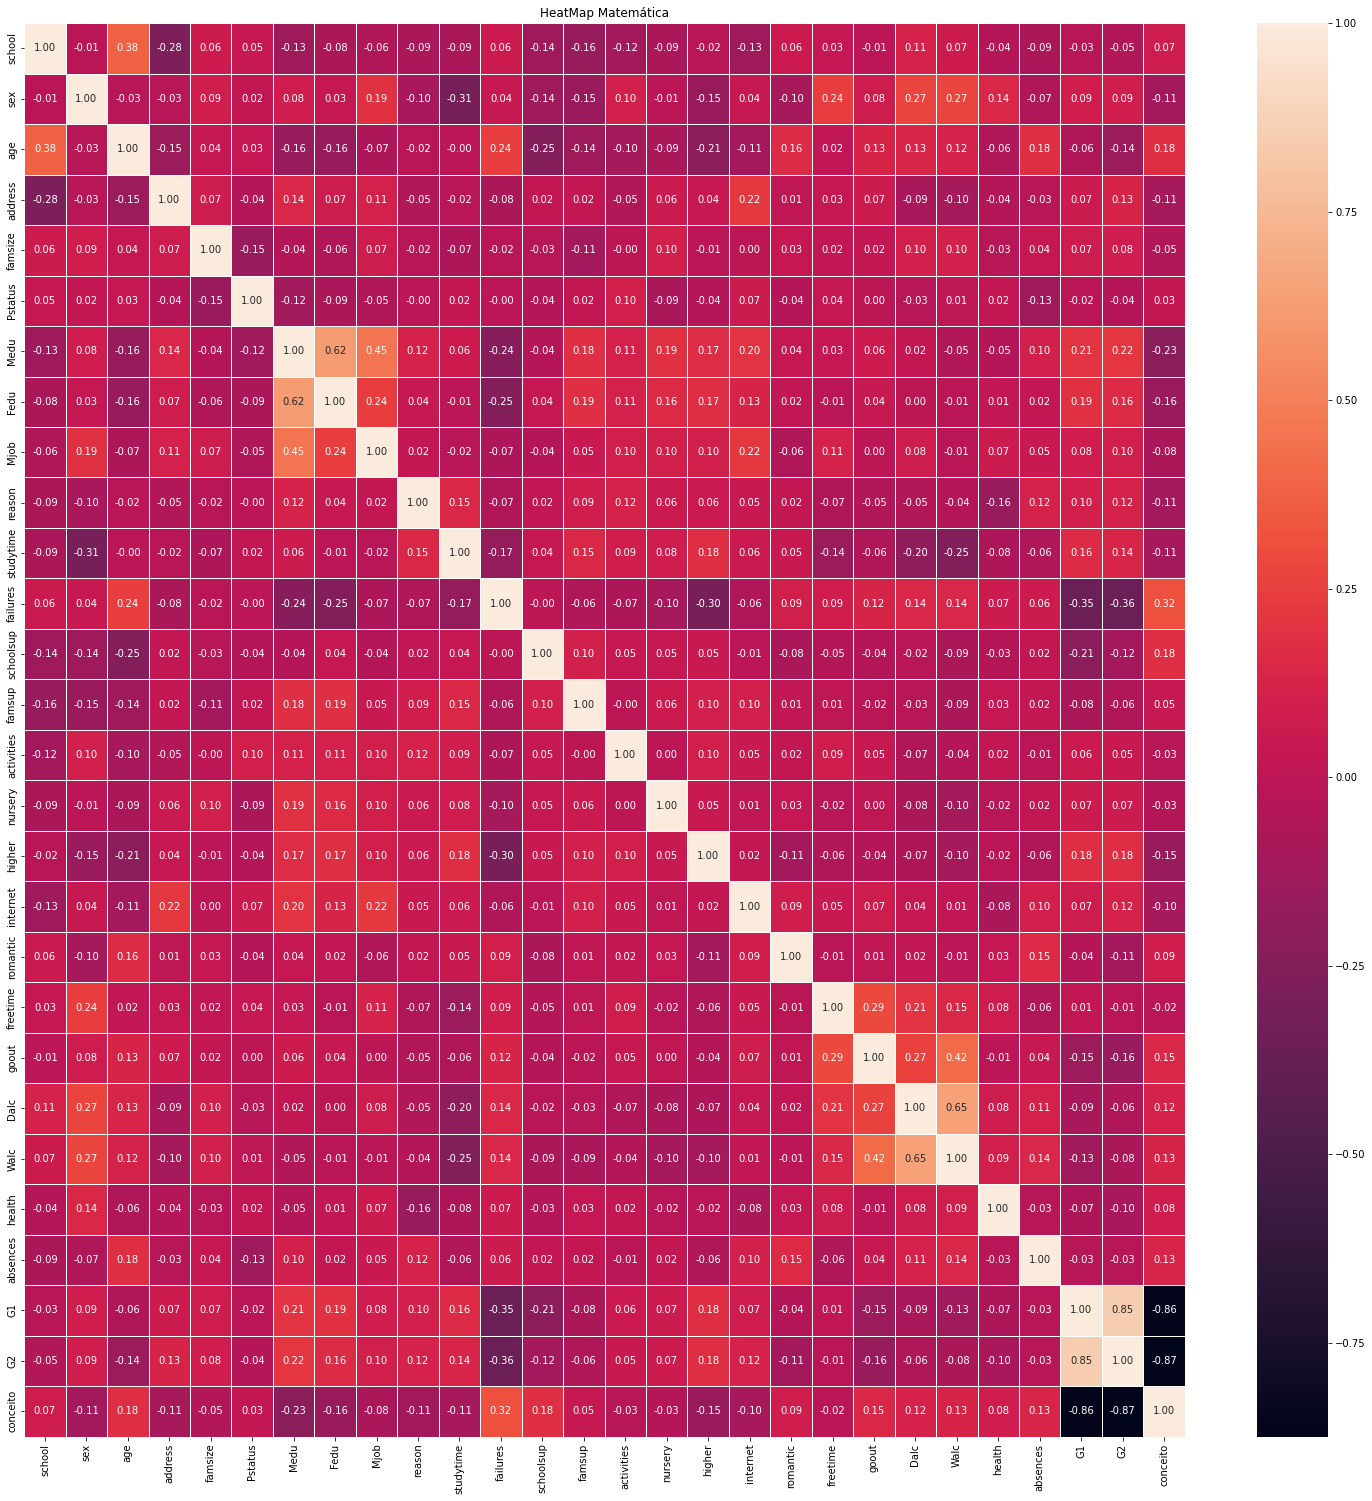

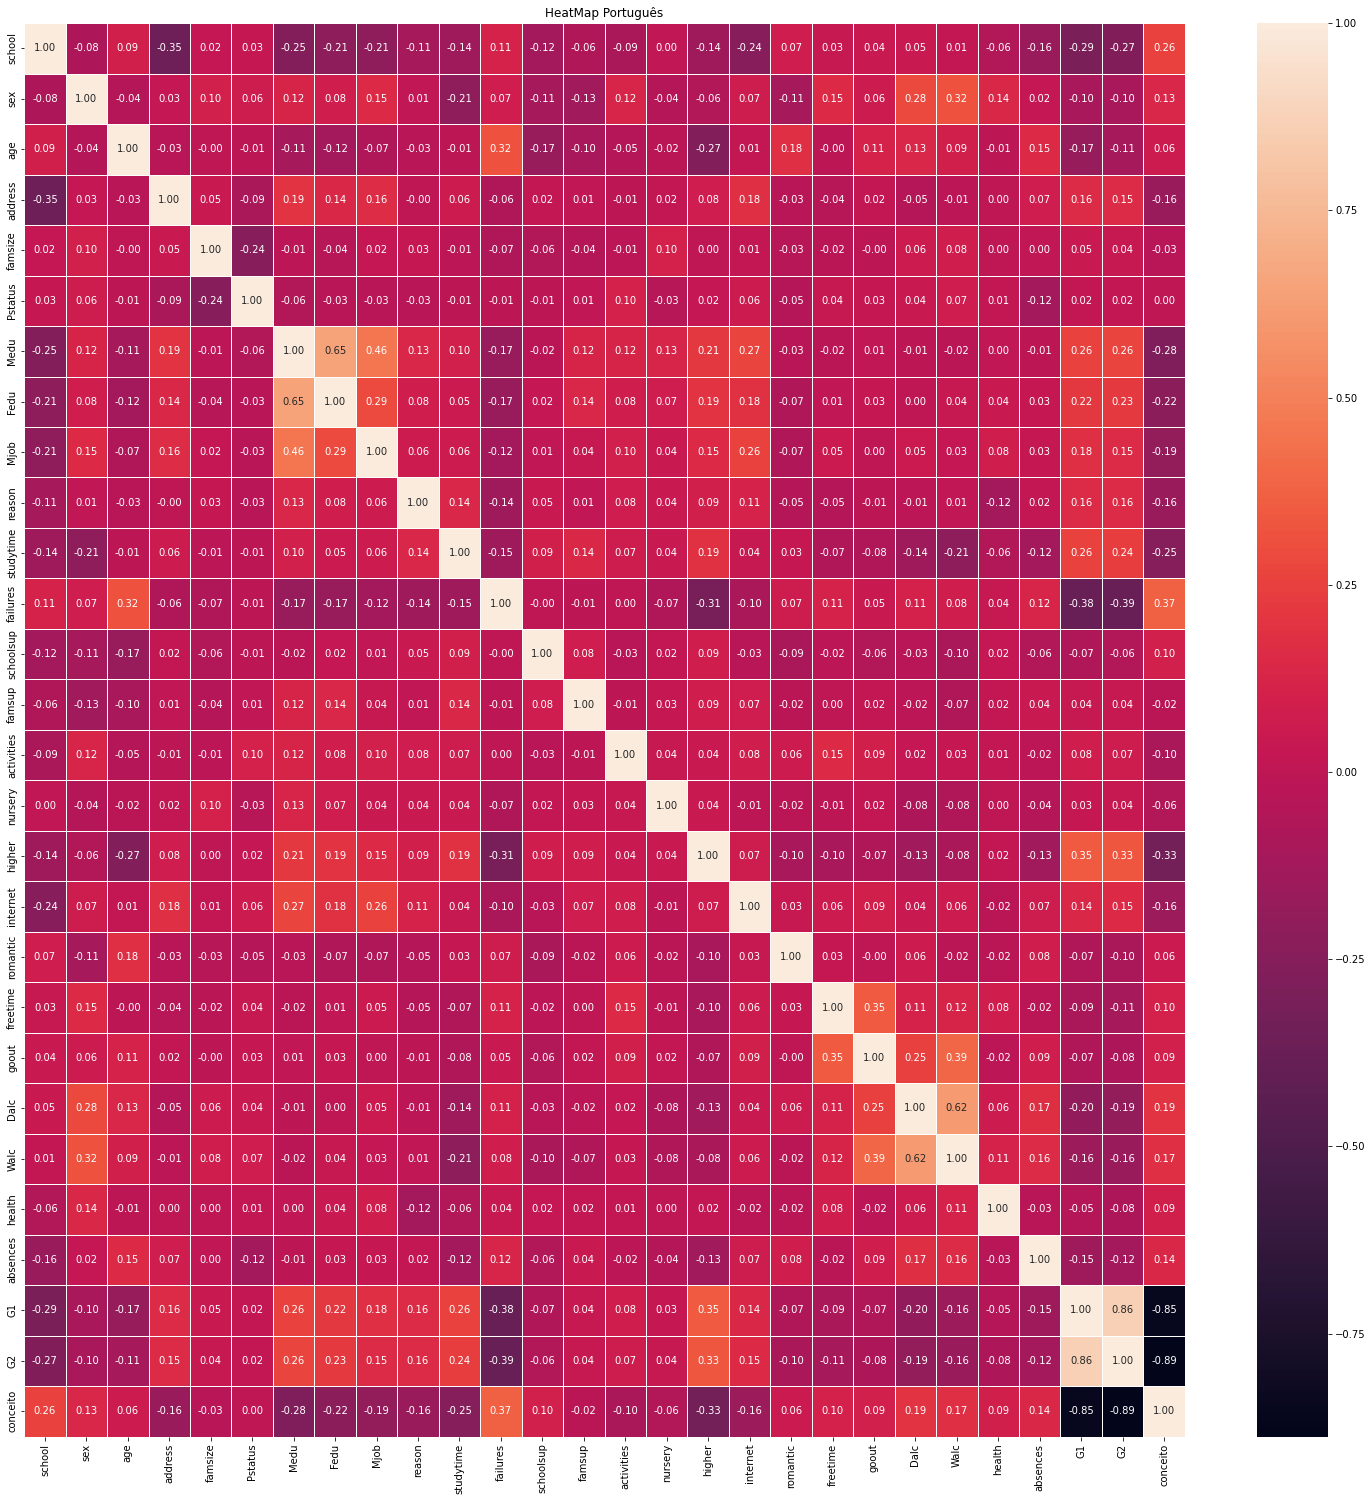

In [40]:
plotCorrelationHeatMap(dataset_mat_proc_conceito, 'HeatMap Matemática')
plotCorrelationHeatMap(dataset_port_proc_conceito, 'HeatMap Português')

### Divisão da base

Divisão da base em treino e teste, sendo 70% para treino e 30% para teste.

In [41]:
def dividirBase(df, atributo_classe):
  X = df.drop(atributo_classe, axis=1)
  Y = df[atributo_classe]

  xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.30)
  return (xTrain, xTest, yTrain, yTest)


In [42]:
# treino_mat, validacao_mat, teste_mat = np.split(dataset_mat.sample(frac=1), [int(.6*len(dataset_mat)), int(.8*len(dataset_mat))])
# treino_port, validacao_port, teste_port = np.split(dataset_port.sample(frac=1), [int(.6*len(dataset_port)), int(.8*len(dataset_port))])

# 'G3', 'conceito'
# attributeToPredict = 'G3'
# X_mat = dataset_mat_proc.drop(attributeToPredict)
# Y_mat = dataset_mat_proc[attributeToPredict]

# xTrain_mat, xTest_mat, yTrain_mat, yTest_mat = dividirBase(dataset_mat_proc, 'G3')
# xTrain_port, xTest_port, yTrain_port, yTest_port = dividirBase(dataset_port_proc, 'G3')

# Modelos de classificação

In [43]:
def computeMetrics(test, prediction, bestEstimator = None):

    metricsDataFrame = {}
    metricsDataFrame['accuracy'] = metrics.accuracy_score(test, prediction)

    metricsDataFrame['precisionMicro'] = metrics.precision_score(test, prediction, average='micro')
    metricsDataFrame['precisionMacro'] = metrics.precision_score(test, prediction, average='macro')
    metricsDataFrame['precisionWeighted'] = metrics.precision_score(test, prediction, average='weighted')

    metricsDataFrame['recallMicro'] = metrics.recall_score(test, prediction, average='micro')
    metricsDataFrame['recallMacro'] = metrics.recall_score(test, prediction, average='macro')
    metricsDataFrame['recallWeighted'] = metrics.recall_score(test, prediction, average='weighted')

    metricsDataFrame['f1Micro'] = metrics.f1_score(test, prediction, average='micro')
    metricsDataFrame['f1Macro'] = metrics.f1_score(test, prediction, average='macro')
    metricsDataFrame['f1Weighted'] = metrics.f1_score(test, prediction, average='weighted')

    if(bestEstimator != None):
        metricsDataFrame['bestEstimator'] = bestEstimator

    return pd.DataFrame(data=metricsDataFrame, index=[0])

In [53]:
from sklearn.model_selection import KFold

In [68]:
def decisionTree(dataset):
    print("Decision Tree")
    model = tree.DecisionTreeClassifier()
    gridSearchParameters = {
        "criterion": ["gini", "entropy"],
        "min_samples_split": [5, 7, 9, 10, 20],
        "max_depth": [6, 7, 8],
        "min_samples_leaf": [4, 5, 6, 8, 10],
        "max_leaf_nodes": [5, 10, 20],
        "max_features": [8, 9, 10, 11, 12, 13, 14]
    }
    

    cv = KFold(n_splits=10, shuffle=True)
    # cv = StratifiedKFold(n_splits=10)

    model = GridSearchCV(model, gridSearchParameters, cv=cv, scoring='accuracy', refit=True, verbose=1, n_jobs=-1) #CV default

    model.fit(dataset['xTrain'], dataset['yTrain'])

    prediction = model.predict(dataset['xTest'])

    metricsDataFrame = computeMetrics(dataset['yTest'], prediction, model.best_estimator_)  

    return metricsDataFrame

# def plotDecisionTree(treeModel, dataset):
#   plotter.style.use('default')
#   fig = plotter.figure(figsize=(60, 20), facecolor='w')
#   tree.plot_tree(treeModel, feature_names = dataset.feature_names, class_names = dataset.target_names, rounded = True, filled = True, fontsize=14)
#   plotter.show()

In [58]:
def SVM(dataset):
    print("SVM")
    COSTS_LIST = [0.025, 0.001, 0.05, 0.01, 0.1, 1, 4, 10, 50, 100, 1000]
    GAMMA_LIST = [0.001, 0.01, 0.1, 1, 10, 50]
    COEFFICIENTS = [0.1, 1, 10, 100]

    gridSearchParameters = [{'C':COSTS_LIST, 'kernel': ['linear']},
  {'C':COSTS_LIST, 'gamma': GAMMA_LIST, 'kernel': ['rbf']},
  {'C':COSTS_LIST, 'gamma': GAMMA_LIST, 'coef0': COEFFICIENTS, 'degree': [1,2,3], 'kernel': ['poly']},
  {'C':COSTS_LIST, 'gamma': GAMMA_LIST, 'coef0': COEFFICIENTS, 'kernel': ['sigmoid']}]
    
    cv = KFold(n_splits=10, shuffle=True)
    # cv = StratifiedKFold(n_splits=10)
    
    model = GridSearchCV(SVC(random_state=42, tol=0.0001), gridSearchParameters, scoring='accuracy', refit=True, verbose=1, n_jobs=-1, cv=cv) #CV default

    model.fit(dataset['xTrain'], dataset['yTrain'])

    prediction = model.predict(dataset['xTest'])

    return computeMetrics(dataset['yTest'], prediction, model.best_estimator_) 

In [60]:
def MLP(dataset):
    print("MLP")
    gridSearchParameters = {'solver': ['lbfgs'], 'max_iter': [35000, 40000, 45000, 50000, 55000 ], 'alpha': 10.0 ** -np.arange(1, 10), 
                            'hidden_layer_sizes':np.arange(10, 15)}
    
    cv = KFold(n_splits=10, shuffle=True)
    # cv = StratifiedKFold(n_splits=10)   
    model = GridSearchCV(MLPClassifier(), gridSearchParameters, scoring='accuracy', refit=True, verbose=1, n_jobs=-1, cv=cv) #CV default

    model.fit(dataset['xTrain'], dataset['yTrain'])

    prediction = model.predict(dataset['xTest'])

    return computeMetrics(dataset['yTest'], prediction, model.best_estimator_)

### Classificando se o aluno será aprovado ou não

In [71]:
def classifyDataFrame(dataFrame, attributeToPredict):
  classifiersFunctions = [{'name': 'Decision Tree', 'function': decisionTree}, 
                          {'name': 'SVM', 'function': SVM}, 
                          {'name': 'MLP', 'function': MLP}]
  dataFrameCopy = dataFrame.copy()

  X = dataFrameCopy.drop(attributeToPredict, axis=1)
  Y = dataFrameCopy[attributeToPredict]
  Y=Y.astype('int')

  xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size=0.30)

#   xTrain = pd.get_dummies(xTrain)
#   xTest = pd.get_dummies(xTest)

  classifiersDataset = {'xTrain': xTrain, 'xTest': xTest, 'yTrain': yTrain, 'yTest': yTest }

  metricsDataFrame = {}

  for classifier in classifiersFunctions:
      metrics = classifier['function'](classifiersDataset)
      if(type(metrics) == dict):
          for key in metrics:
              metricsDataFrame[key] = metrics[key]
      else:
          metricsDataFrame[classifier['name']] = metrics

  return metricsDataFrame

In [72]:
dataset_mat_final_res = classifyDataFrame(dataset_mat_proc_final, 'aprovado')
dataset_port_final_res = classifyDataFrame(dataset_port_proc_final, 'aprovado')

df_mat_final = []
df_port_final = []

for col in dataset_mat_final_res:
    df_mat_final.append(dataset_mat_final_res[col])

for col in dataset_port_final_res:
    df_port_final.append(dataset_port_final_res[col])

pd.concat(df_mat_final).to_csv('metricasMatFinal.csv')
pd.concat(df_port_final).to_csv('metricasPortFinal.csv')

Decision Tree
Fitting 10 folds for each of 3150 candidates, totalling 31500 fits
SVM
Fitting 10 folds for each of 1133 candidates, totalling 11330 fits
MLP
Fitting 10 folds for each of 225 candidates, totalling 2250 fits
Decision Tree
Fitting 10 folds for each of 3150 candidates, totalling 31500 fits
SVM
Fitting 10 folds for each of 1133 candidates, totalling 11330 fits
MLP
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


In [73]:
dataset_mat_conceito_res = classifyDataFrame(dataset_mat_proc_conceito, 'conceito')
dataset_port_conceito_res = classifyDataFrame(dataset_port_proc_conceito, 'conceito')

df_mat_conceito = []
df_port_conceito = []

for col in dataset_mat_conceito_res:
    df_mat_conceito.append(dataset_mat_conceito_res[col])

for col in dataset_port_conceito_res:
    df_port_conceito.append(dataset_mat_conceito_res[col])

pd.concat(df_mat_conceito).to_csv('metricasMatConceito.csv')
pd.concat(df_port_conceito).to_csv('metricasPortConceito.csv')

Decision Tree
Fitting 10 folds for each of 3150 candidates, totalling 31500 fits
SVM
Fitting 10 folds for each of 1133 candidates, totalling 11330 fits
MLP
Fitting 10 folds for each of 225 candidates, totalling 2250 fits
Decision Tree
Fitting 10 folds for each of 3150 candidates, totalling 31500 fits
SVM
Fitting 10 folds for each of 1133 candidates, totalling 11330 fits
MLP
Fitting 10 folds for each of 225 candidates, totalling 2250 fits
